In [6]:
# imports
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as td
import seaborn as sns

In [7]:
# read in data from sql queries
# NaN values mean not found in query (but not an error!)
rh = pd.read_csv('../outputs/rabbithole_forpandas.csv')
rh.head(3)

,address,num_txns,first_txn_date,last_txn_date,first_chain,address_chain,first_completion_date,NFT_1,NFT_2,NFT_3,...,NFT_5,NFT_6,NFT_7,NFT_8,NFT_9,NFT_10,NFT_11,NFT_12,NFT_13,total_nfts
0,0xefbc9ff5e62628ac140d7e76b88c73ff5fcd86bf,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x3714c0b6f3c69016974db061b534006075225e21,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x841f9b2f645df4755ba8d0391d65e6f2228eab42,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Answering Question #1: Age of wallets

In [8]:
# drop the wallet addresses that have 0 "out" transactions
# convert first txn date to a datetime object
# create new column for txn year (to use for visual analysis and grouping)
actuals = rh[rh['num_txns'] != 0].reset_index()
actuals['first_txn_date'] = [dt.strptime(actuals['first_txn_date'][row], '%Y-%m-%d') for row in range(len(actuals))]
actuals['first_txn_year'] = [actuals['first_txn_date'][row].year for row in range(len(actuals))]
actuals.head(3)

,index,address,num_txns,first_txn_date,last_txn_date,first_chain,address_chain,first_completion_date,NFT_1,NFT_2,...,NFT_6,NFT_7,NFT_8,NFT_9,NFT_10,NFT_11,NFT_12,NFT_13,total_nfts,first_txn_year
0,1928,0x70b99c19d3aaaa1535bfec201af1924b7252eeaf,100,2019-08-04,2020-06-19,ethereum,both,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
1,1929,0xc3f3f187cd44b1c4ef00da50c78422c9ec47e1c1,20,2021-01-28,2021-03-02,ethereum,both,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
2,1930,0xeeaf61935c0c48f8f8cc28c381683d7fa2f75e1c,636,2021-01-30,2021-03-02,ethereum,both,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021


In [16]:
# calculate counts and percentages of wallets by first transaction year
# pretty print output
counts = actuals.groupby('first_txn_year').count()['index']
percentages = (100 * actuals.groupby('first_txn_year').count() / len(actuals))['index']

print('NUMBER OF WALLETS WITH FIRST TRANSACTION IN EACH YEAR')
print('------------')
print(counts)
print('\n')
print('PERCENT OF WALLETS WITH FIRST TRANSACTION IN EACH YEAR')
print('------------')
print(percentages)

NUMBER OF WALLETS WITH FIRST TRANSACTION IN EACH YEAR
------------
first_txn_year
2016       15
2017      835
2018     1475
2019      858
2020     4095
2021    27252
Name: index, dtype: int64


PERCENT OF WALLETS WITH FIRST TRANSACTION IN EACH YEAR
------------
first_txn_year
2016     0.043440
2017     2.418187
2018     4.271648
2019     2.484796
2020    11.859253
2021    78.922676
Name: index, dtype: float64


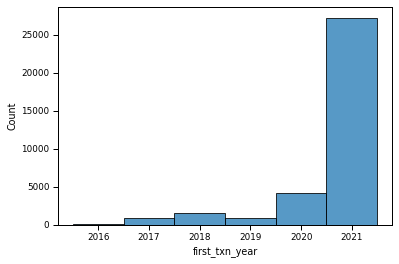

In [17]:
# visualize and save data
sns.set_context('paper')
hist = sns.histplot(actuals['first_txn_year'], discrete=True, stat='count')
fig = hist.get_figure()
fig.savefig('../figures/wallet_creation_counts.jpeg')

## Answering Question #2: Time before quest completion

In [19]:
# select addresses that have completed at least one quest
questors = rh[~rh['total_nfts'].isna()].reset_index()
percent_questors = (len(questors) / len(rh)) * 100
print(f'{len(questors)} out of {len(rh)} total wallet addresses \
({round(percent_questors, 1)}%) have completed at least one quest')

8692 out of 36458 total wallet addresses (23.8%) have completed at least one quest


In [22]:
# remove addresses with no "out" txns
non_ghosts = questors[~questors['first_txn_date'].isna()].reset_index()
percent_ghosts = (1 - (len(non_ghosts) / len(questors))) * 100
print(f'Out of the addresses that possess at least one quest NFT, \
{len(questors)-len(non_ghosts)} ({round(percent_ghosts, 1)}%) have \
no visible txn history')
print('They will be excluded from analysis')

Out of the addresses that possess at least one quest NFT, 1115 (12.8%) have no visible txn history
They will be excluded from analysis


In [23]:
# change data types and calculate days between first txn and first quest
# removing any wallets that completed a quest before their first out transaction
non_ghosts['first_txn_date'] = [dt.strptime(non_ghosts['first_txn_date'][row], '%Y-%m-%d') for row in range(len(non_ghosts))]
non_ghosts['last_txn_date'] = [dt.strptime(non_ghosts['last_txn_date'][row], '%Y-%m-%d') for row in range(len(non_ghosts))]
non_ghosts['first_completion_date'] = [dt.strptime(non_ghosts['first_completion_date'][row], '%Y-%m-%d') for row in range(len(non_ghosts))]
non_ghosts['days_between'] = [(non_ghosts['first_completion_date'][row] - non_ghosts['first_txn_date'][row]).days for row in range(len(non_ghosts))]
non_ghosts = non_ghosts[non_ghosts['days_between'] >= 0]

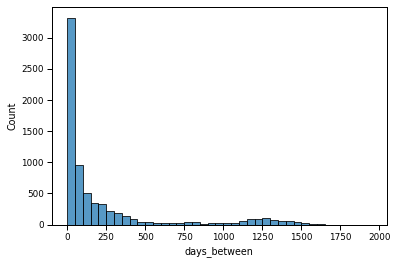

In [24]:
# visualize data and save
sns.set_context('paper')
hist = sns.histplot(non_ghosts['days_between'], binwidth=50)
fig = hist.get_figure()
fig.savefig('../figures/quest_completion_counts.jpeg')

In [28]:
# pretty print descriptive statistics
print('min, max and quartiles for days between first txn and first quest')
print('-------------')
print(non_ghosts['days_between'].describe()[3:])

min, max and quartiles for days between first txn and first quest
-------------
min       0.0
25%       2.0
50%      62.0
75%     227.0
max    1908.0
Name: days_between, dtype: float64
